In [2]:
import pandas as pd
import numpy as np
import torch
import os
from tqdm import tqdm
import pickle
import gc
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
data_path = "/home/joaquino/portuguese-llm/data/merged_data_lemm.parquet"
df = pd.read_parquet(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (24000, 27)
Columns: ['messageId', 'message', 'trait', 'original_prompt', 'model', 'response', 'responseId', 'udpipe_result', 'MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media', 'profundidade_max', 'ttr', 'lexical_density', 'token_quantity', 'adjective_list', 'substantive_list', 'genero', 'raca', 'regiao', 'localidade', 'unused', 'artigo', 'pronome', 'response_lemm']

First few rows:


,messageId,message,trait,original_prompt,model,response,responseId,udpipe_result,MLC,MLS,...,adjective_list,substantive_list,genero,raca,regiao,localidade,unused,artigo,pronome,response_lemm
0,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nascido e criado no Nor...",407b48b9-b0ed-5658-bba7-4180c43cd30c,"# generator = UDPipe 2, https://lindat.mff.cun...",20.272727,24.777778,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nascer e criar _ em o No...
1,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem preto, nascido e criado no Nor...",68156cbb-c93c-5d05-9ba6-cbb2e6d6ee55,"# generator = UDPipe 2, https://lindat.mff.cun...",22.000000,26.888889,...,"[{'id': 5, 'form': 'preto', 'lemma': 'preto', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem preto nascer e criar _ em o No...
2,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nordestino e carrego em...",da84a465-0723-5ccd-a449-65c89840bc1e,"# generator = UDPipe 2, https://lindat.mff.cun...",18.266667,27.400000,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nordestino e carregar em...
3,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, natural do Norte do Bra...",91f9690e-b62d-54dc-a365-9803475f3433,"# generator = UDPipe 2, https://lindat.mff.cun...",32.375000,21.583333,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro natural _ de o Norte _ d...
4,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nascido e criado no Nor...",aa059409-4765-5520-9caf-348a2c2911ee,"# generator = UDPipe 2, https://lindat.mff.cun...",15.722222,25.727273,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nascer e criar _ em o No...


In [4]:
# Improved helper function for loading embeddings as DataFrame with better organization
def load_embeddings_dataframe_with_responseId(embeddings_dir="/home/joaquino/portuguese-llm/embeddings/bert_embeddings", 
                                              responseId_first=True,
                                              as_tensor=False):
    """
    Load BERT embeddings as pandas DataFrame with responseId column
    
    Args:
        embeddings_dir (str): Directory containing the embeddings
        responseId_first (bool): If True, puts responseId as the first column for easier access
        as_tensor (bool): If True, returns embeddings as PyTorch tensors in a single column
    
    Returns:
        pd.DataFrame: DataFrame with responseId and embedding dimensions
                     - If as_tensor=True: columns are ['responseId', 'embedding'] where embedding is a torch.Tensor
                     - If responseId_first=True: columns are ['responseId', '0', '1', ..., 'n']
                     - If responseId_first=False: columns are ['0', '1', ..., 'n', 'responseId']
    """
    # Load the parquet file
    df_file = os.path.join(embeddings_dir, "bert_embeddings_df.parquet")
    
    if not os.path.exists(df_file):
        raise FileNotFoundError(f"Embedding DataFrame file not found: {df_file}")
    
    df = pd.read_parquet(df_file)
    
    if as_tensor:
        # Convert embedding columns to torch tensors
        embedding_cols = [col for col in df.columns if col != 'responseId']
        
        # Convert each row of embeddings to a torch tensor
        embeddings_as_tensors = []
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Converting to tensors"):
            # Get embedding values and ensure they're float32
            embedding_values = row[embedding_cols].values
            
            # Convert to float32 numpy array first to handle any type issues
            try:
                embedding_values = embedding_values.astype(np.float32)
            except (ValueError, TypeError) as e:
                print(f"Error converting row {idx} to float32: {e}")
                print(f"Row data types: {row[embedding_cols].dtypes}")
                print(f"Row values sample: {embedding_values[:5]}")
                raise
            
            # Now convert to torch tensor
            tensor_embedding = torch.from_numpy(embedding_values)
            embeddings_as_tensors.append(tensor_embedding)
        
        # Create new DataFrame with responseId and tensor embeddings
        result_df = pd.DataFrame({
            'responseId': df['responseId'].values,
            'embedding': embeddings_as_tensors
        })
        
        return result_df
    
    elif responseId_first:
        # Reorganize columns to put responseId first
        embedding_cols = [col for col in df.columns if col != 'responseId']
        df = df[['responseId'] + embedding_cols]
    
    return df

In [5]:
# Load embeddings as DataFrame with PyTorch tensors
df_with_responseId = load_embeddings_dataframe_with_responseId(as_tensor=True)

print(f"DataFrame shape: {df_with_responseId.shape}")
print(f"Columns: {list(df_with_responseId.columns)}")
print(f"First embedding tensor shape: {df_with_responseId['embedding'].iloc[0].shape}")
print(f"First embedding tensor type: {type(df_with_responseId['embedding'].iloc[0])}")

# Show first few rows
print("\nFirst few rows:")
df_with_responseId.head(3)

Converting to tensors: 100%|██████████| 24000/24000 [00:34<00:00, 691.30it/s]



DataFrame shape: (24000, 2)
Columns: ['responseId', 'embedding']
First embedding tensor shape: torch.Size([1024])
First embedding tensor type: <class 'torch.Tensor'>

First few rows:


,responseId,embedding
0,407b48b9-b0ed-5658-bba7-4180c43cd30c,"[tensor(0.2816), tensor(0.1334), tensor(0.0859..."
1,68156cbb-c93c-5d05-9ba6-cbb2e6d6ee55,"[tensor(-0.3456), tensor(0.0247), tensor(0.021..."
2,da84a465-0723-5ccd-a449-65c89840bc1e,"[tensor(0.3745), tensor(0.2789), tensor(0.3072..."


## Cosines distances

In [6]:
merged_df = df.merge(df_with_responseId, on='responseId', how='inner')

In [30]:
config_cols = ['genero', 'raca', 'regiao', "model",'original_prompt']

In [31]:
# Analysis with model filtering control
selected_model = "all"  # Change this to specific model name or "all"
# Available models: merged_df['model'].unique()

print(f"Available models: {sorted(merged_df['model'].unique())}")
print(f"Selected model: {selected_model}")

# Filter data based on model selection
if selected_model == "all":
    filtered_df = merged_df.copy()
    print(f"Using all models: {len(filtered_df)} rows")
else:
    filtered_df = merged_df[merged_df['model'] == selected_model].copy()
    print(f"Filtering to model='{selected_model}': {len(filtered_df)} rows")

Available models: ['gemini-1.5-flash', 'gemini-2.0-flash', 'gpt-4o', 'gpt-4o-mini']
Selected model: all
Using all models: 24000 rows


In [32]:
# Calculate mean embeddings grouped by messageId
def calculate_mean_embedding(group):
    embeddings_list = group['embedding'].tolist()
    stacked_embeddings = torch.stack(embeddings_list)
    mean_embedding = torch.mean(stacked_embeddings, dim=0)
    
    # Get config values (same for all responses in group)
    config_values = group[config_cols].iloc[0]
    
    result = {'mean_embedding': mean_embedding}
    result.update(config_values.to_dict())
    
    return pd.Series(result)

# Group by messageId and calculate mean embeddings with config
grouped = filtered_df.groupby('messageId').apply(calculate_mean_embedding)

mean_embeddings_df = grouped.reset_index()

print(f"Mean embeddings with config: {mean_embeddings_df.shape}")
print(f"Columns: {list(mean_embeddings_df.columns)}")
mean_embeddings_df.head()

Mean embeddings with config: (2400, 7)
Columns: ['messageId', 'mean_embedding', 'genero', 'raca', 'regiao', 'model', 'original_prompt']


,messageId,mean_embedding,genero,raca,regiao,model,original_prompt
0,001d90e7-d0db-567e-83b3-e5da536359e9,"[tensor(-0.0427), tensor(0.2261), tensor(0.509...",homem,preta,sulista,gemini-2.0-flash,<user>\n Imagine que você é uma pessoa {{ge...
1,001fbe3b-d84b-5428-9d90-4ce0bd12c055,"[tensor(0.0581), tensor(0.3452), tensor(-0.321...",não-binária,amarela,sulista,gemini-2.0-flash,<user>\n Imagine uma pessoa {{raca}} {{gene...
2,005bd095-a332-54d5-93fb-8e10d84e7aa1,"[tensor(0.4885), tensor(0.0735), tensor(0.1691...",mulher,preta,nortista,gemini-2.0-flash,<user>\n Imagine uma pessoa {{genero}} {{ra...
3,006444d8-fc21-5caf-9154-3d08827d1902,"[tensor(-0.3232), tensor(0.4686), tensor(-0.31...",não-binária,preta,centro-oestina,gemini-2.0-flash,<user>\n Imagine uma pessoa {{raca}} {{gene...
4,008662a4-215d-54fc-a024-603eaa2380b3,"[tensor(-0.1262), tensor(0.5302), tensor(0.131...",homem,amarela,nordestina,gemini-1.5-flash,<user>\n Descreva uma pessoa {{genero}} {{r...


In [33]:
def calculate_config_match_percentage(row1, row2, config_columns):
    """
    Calculate the percentage of configuration values that match between two rows.
    
    Args:
        row1, row2: DataFrame rows to compare
        config_columns: List of column names to compare
        
    Returns:
        float: Percentage of matching config values (0-100)
    """
    matches = 0
    total = len(config_columns)
    
    for col in config_columns:
        if row1[col] == row2[col]:
            matches += 1
    
    return (matches / total) * 100 if total > 0 else 0

In [42]:
# Cluster metrics using mean embeddings as centroids - Scientific Research Version
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_cluster_metrics_scientific(embeddings_df, config_col):
    """
    Calculate key cluster metrics with both scientific names and interpretations
    """
    # Get unique values and their embeddings
    clusters = {}
    all_embeddings = []
    
    for value in embeddings_df[config_col].unique():
        subset = embeddings_df[embeddings_df[config_col] == value]
        embeddings_list = subset['mean_embedding'].tolist()
        
        if embeddings_list:
            stacked_embeddings = torch.stack(embeddings_list)
            centroid = torch.mean(stacked_embeddings, dim=0)
            
            clusters[value] = {
                'centroid': centroid,
                'embeddings': stacked_embeddings,
                'count': len(embeddings_list)
            }
            
            all_embeddings.extend([emb.numpy() for emb in embeddings_list])
    
    metrics = {}
    
    # 1. WITHIN-CLUSTER SUM OF SQUARES (WCSS) / INERTIA
    # Scientific name: Within-Cluster Sum of Squares
    # Interpretation: Cluster Tightness (Lower = Better)
    wcss_total = 0
    avg_within_distances = []
    for value, cluster_info in clusters.items():
        embeddings = cluster_info['embeddings']
        centroid = cluster_info['centroid']
        distances = torch.norm(embeddings - centroid.unsqueeze(0), dim=1)
        wcss = torch.sum(distances ** 2).item()
        wcss_total += wcss
        
        avg_distance = torch.mean(distances).item()
        avg_within_distances.append(avg_distance)
        cluster_info['avg_within_distance'] = avg_distance
        cluster_info['wcss'] = wcss
    
    metrics['wcss'] = wcss_total
    metrics['inertia'] = wcss_total  # Same as WCSS
    metrics['avg_intra_cluster_distance'] = np.mean(avg_within_distances)
    
    # 2. BETWEEN-CLUSTER SEPARATION
    # Scientific name: Between-Cluster Sum of Squares (BCSS) / Inter-cluster Distance
    # Interpretation: Cluster Separation (Higher = Better)
    inter_distances = []
    cluster_list = list(clusters.items())
    n_total_samples = sum(cluster['count'] for cluster in clusters.values())
    overall_centroid = torch.mean(torch.cat([cluster['embeddings'] for cluster in clusters.values()]), dim=0)
    
    bcss_total = 0
    for value, cluster_info in clusters.items():
        centroid = cluster_info['centroid']
        count = cluster_info['count']
        distance_sq = torch.norm(centroid - overall_centroid) ** 2
        bcss_total += count * distance_sq.item()
    
    # Average inter-cluster centroid distance
    for i, (val1, cluster1) in enumerate(cluster_list):
        for j, (val2, cluster2) in enumerate(cluster_list):
            if i < j:  # avoid duplicates
                distance = torch.norm(cluster1['centroid'] - cluster2['centroid']).item()
                inter_distances.append(distance)
    
    metrics['bcss'] = bcss_total
    metrics['avg_inter_cluster_distance'] = np.mean(inter_distances) if inter_distances else 0
    
    # 3. CALINSKI-HARABASZ INDEX (Variance Ratio Criterion)
    # Scientific name: Calinski-Harabasz Index
    # Interpretation: Cluster Quality (Higher = Better)
    n_samples = n_total_samples
    n_clusters = len(clusters)
    if n_clusters > 1 and n_samples > n_clusters:
        ch_index = (bcss_total / (n_clusters - 1)) / (wcss_total / (n_samples - n_clusters))
        metrics['calinski_harabasz_index'] = ch_index
    else:
        metrics['calinski_harabasz_index'] = 0
    
    # 4. CLUSTER BALANCE (Coefficient of Variation)
    # Scientific name: Coefficient of Variation of Cluster Sizes
    # Interpretation: Cluster Balance (Lower = Better)
    cluster_sizes = [cluster['count'] for cluster in clusters.values()]
    if len(cluster_sizes) > 1:
        cv = np.std(cluster_sizes) / np.mean(cluster_sizes)
        metrics['cluster_size_cv'] = cv
    else:
        metrics['cluster_size_cv'] = 0
    
    # 5. TOTAL SUM OF SQUARES
    metrics['tss'] = wcss_total + bcss_total
    
    # 6. EXPLAINED VARIANCE RATIO (R²)
    # Scientific name: Between-cluster variance / Total variance
    if metrics['tss'] > 0:
        metrics['explained_variance_ratio'] = bcss_total / metrics['tss']
    else:
        metrics['explained_variance_ratio'] = 0
        
    return metrics, clusters

def bootstrap_metric_scientific(embeddings_df, config_col, metric_func, n_bootstrap=50):
    """Calculate bootstrap confidence intervals for metrics"""
    bootstrap_results = []
    n_samples = len(embeddings_df)
    
    for i in range(n_bootstrap):
        
        # Bootstrap sample
        boot_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_sample = embeddings_df.iloc[boot_indices].reset_index(drop=True)
        
        # Calculate metrics on bootstrap sample
        try:
            metrics, _ = metric_func(boot_sample, config_col)
            bootstrap_results.append(metrics)
        except:
            continue  # Skip failed bootstrap samples
    
    # Calculate confidence intervals
    ci_metrics = {}
    if bootstrap_results:
        for metric_name in bootstrap_results[0].keys():
            values = [result[metric_name] for result in bootstrap_results if metric_name in result and not np.isnan(result[metric_name])]
            if len(values) > 5:  # Need sufficient samples
                ci_lower = np.percentile(values, 2.5)
                ci_upper = np.percentile(values, 97.5)
                mean_val = np.mean(values)
                ci_metrics[metric_name] = {
                    'mean': mean_val,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'ci_width': ci_upper - ci_lower,
                    'n_bootstrap': len(values)
                }
    
    return ci_metrics

all_metrics = {}
all_clusters = {}
all_ci_metrics = {}

for config_col in config_cols:
    print(f"\nAnalyzing {config_col}...")
    
    # Calculate point estimates
    metrics, clusters = calculate_cluster_metrics_scientific(mean_embeddings_df, config_col)
    all_metrics[config_col] = metrics
    all_clusters[config_col] = clusters

    ci_metrics = bootstrap_metric_scientific(mean_embeddings_df, config_col, calculate_cluster_metrics_scientific, n_bootstrap=50)
    all_ci_metrics[config_col] = ci_metrics

print(f"\n{'='*80}")
print("SCIENTIFIC METRIC DEFINITIONS:")
print("• WCSS: Within-Cluster Sum of Squares (lower = tighter clusters)")
print("• BCSS: Between-Cluster Sum of Squares (higher = better separation)")
print("• Calinski-Harabasz Index: Ratio of between/within cluster variance (higher = better)")
print("• Explained Variance Ratio (R²): Proportion of variance explained by clustering")
print("• Coefficient of Variation: Measure of cluster size balance (lower = more balanced)")
print("=" * 80)


Analyzing genero...

Analyzing raca...

Analyzing raca...

Analyzing regiao...

Analyzing regiao...

Analyzing model...

Analyzing model...

Analyzing original_prompt...

Analyzing original_prompt...

SCIENTIFIC METRIC DEFINITIONS:
• WCSS: Within-Cluster Sum of Squares (lower = tighter clusters)
• BCSS: Between-Cluster Sum of Squares (higher = better separation)
• Calinski-Harabasz Index: Ratio of between/within cluster variance (higher = better)
• Explained Variance Ratio (R²): Proportion of variance explained by clustering
• Coefficient of Variation: Measure of cluster size balance (lower = more balanced)

SCIENTIFIC METRIC DEFINITIONS:
• WCSS: Within-Cluster Sum of Squares (lower = tighter clusters)
• BCSS: Between-Cluster Sum of Squares (higher = better separation)
• Calinski-Harabasz Index: Ratio of between/within cluster variance (higher = better)
• Explained Variance Ratio (R²): Proportion of variance explained by clustering
• Coefficient of Variation: Measure of cluster size b

In [35]:
# Calculate silhouette scores separately (this may take some time)
from sklearn.metrics import silhouette_score

def calculate_silhouette_scores(embeddings_df, config_col):
    """Calculate silhouette scores for each configuration"""
    subset = embeddings_df[embeddings_df[config_col].notna()].copy()
    if len(subset) < 2:
        return 0
    
    # Convert embeddings to numpy array
    embeddings_array = torch.stack(subset['mean_embedding'].tolist()).numpy()
    labels = subset[config_col].values
    
    try:
        score = silhouette_score(embeddings_array, labels)
        return score
    except:
        return 0

# Calculate silhouette scores for all configs (this is the slow part)
print("Calculating silhouette scores (this may take a while)...")
silhouette_scores = {}
for config_col in config_cols:
    print(f"  Computing silhouette for {config_col}...")
    silhouette_scores[config_col] = calculate_silhouette_scores(mean_embeddings_df, config_col)

print("Silhouette scores calculated:")
for config_col, score in silhouette_scores.items():
    print(f"  {config_col}: {score:.4f}")

Calculating silhouette scores (this may take a while)...
  Computing silhouette for genero...
  Computing silhouette for raca...
  Computing silhouette for raca...
  Computing silhouette for regiao...
  Computing silhouette for regiao...
  Computing silhouette for model...
  Computing silhouette for model...
  Computing silhouette for original_prompt...
Silhouette scores calculated:
  genero: 0.1014
  raca: 0.0105
  regiao: 0.0122
  model: 0.0392
  original_prompt: 0.0019
  Computing silhouette for original_prompt...
Silhouette scores calculated:
  genero: 0.1014
  raca: 0.0105
  regiao: 0.0122
  model: 0.0392
  original_prompt: 0.0019


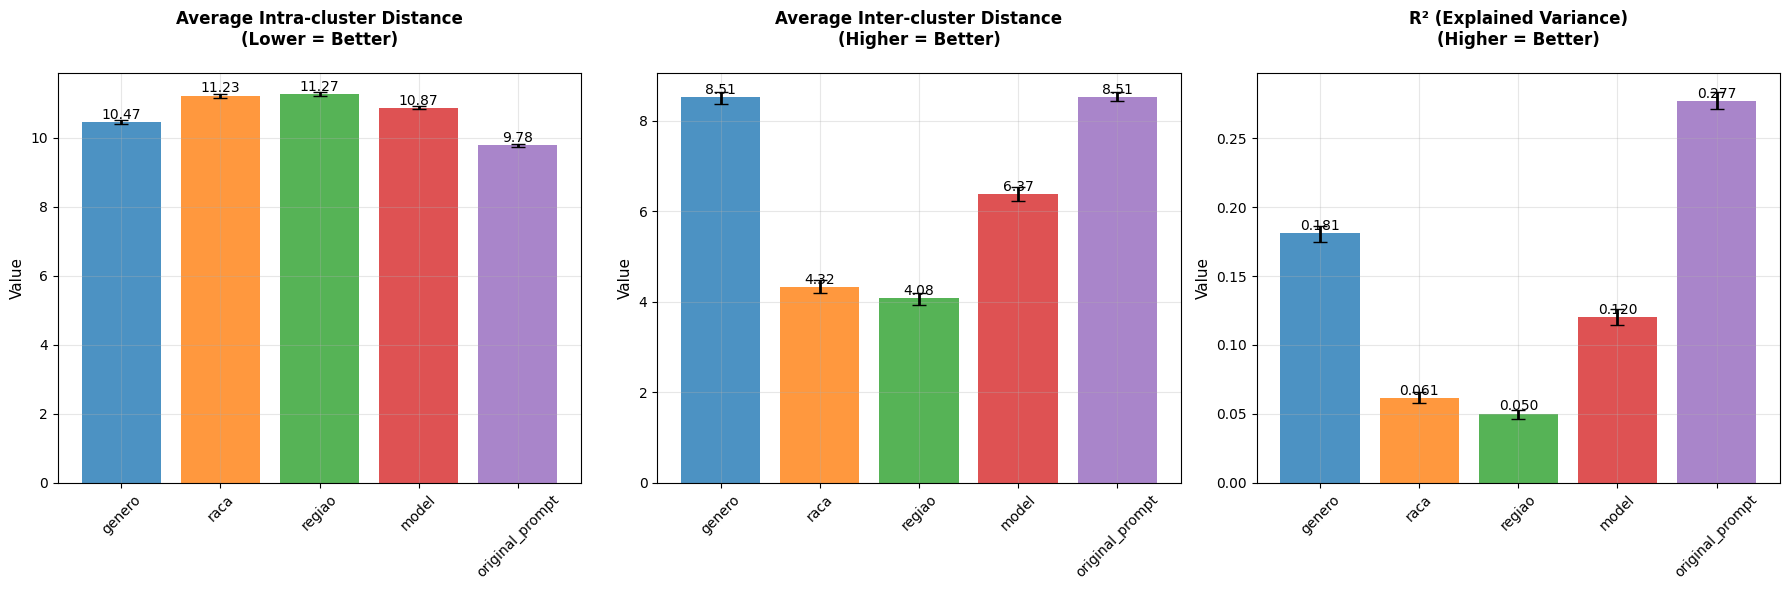

In [38]:
# Clustering metrics comparison - where original_prompt performs best
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplot with 3 metrics where original_prompt wins
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Define metrics where original_prompt is best
original_prompt_wins = [
    ('avg_intra_cluster_distance', 'Average Intra-cluster Distance\n(Lower = Better)', True),
    ('avg_inter_cluster_distance', 'Average Inter-cluster Distance\n(Higher = Better)', False),
    ('explained_variance_ratio', 'R² (Explained Variance)\n(Higher = Better)', False)
]

# Use seaborn color palette
colors = sns.color_palette("tab10", n_colors=len(config_cols))

for i, (metric_name, title, lower_better) in enumerate(original_prompt_wins):
    # Extract values and confidence intervals
    values = []
    ci_lowers = []
    ci_uppers = []
    
    for col in config_cols:
        if metric_name in all_ci_metrics[col]:
            ci_data = all_ci_metrics[col][metric_name]
            values.append(ci_data['mean'])
            ci_lowers.append(ci_data['mean'] - ci_data['ci_lower'])
            ci_uppers.append(ci_data['ci_upper'] - ci_data['mean'])
        else:
            values.append(all_metrics[col][metric_name])
            ci_lowers.append(0)
            ci_uppers.append(0)
    
    # Create bar plot with error bars using the color palette
    bars = axes[i].bar(config_cols, values, color=colors, alpha=0.8, 
                      yerr=[ci_lowers, ci_uppers], capsize=5, error_kw={'linewidth': 2})
    
    axes[i].set_title(title, fontsize=12, fontweight='bold', pad=20)
    axes[i].set_ylabel('Value', fontsize=11)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for j, (bar, value) in enumerate(zip(bars, values)):
        height = bar.get_height()
        if height >= 0:
            label_y = height + max(ci_uppers) * 0.02 if max(ci_uppers) > 0 else height * 1.02
        else:
            label_y = height * 0.98
        
        # Format numbers appropriately
        if abs(value) >= 1000:
            label = f'{value:.0f}'
        elif abs(value) >= 1:
            label = f'{value:.2f}'
        else:
            label = f'{value:.3f}'
        
        axes[i].text(bar.get_x() + bar.get_width()/2., label_y,
                    label, ha='center', va='bottom', fontweight='normal', fontsize=10)

plt.tight_layout()
plt.show()

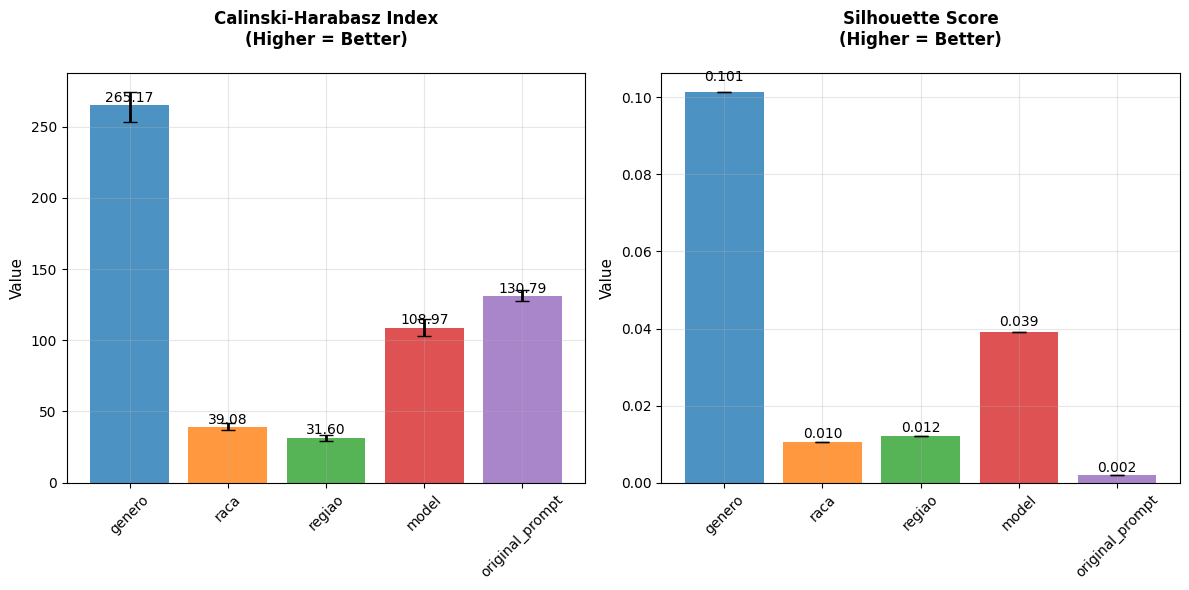

In [39]:
# Additional clustering quality measures
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define metrics where other configs might perform better
other_configs_win = [
    ('calinski_harabasz_index', 'Calinski-Harabasz Index\n(Higher = Better)', False),
    ('silhouette', 'Silhouette Score\n(Higher = Better)', False)
]

# Use seaborn color palette
colors = sns.color_palette("tab10", n_colors=len(config_cols))

for i, (metric_name, title, lower_better) in enumerate(other_configs_win):
    # Extract values and confidence intervals
    values = []
    ci_lowers = []
    ci_uppers = []
    
    for col in config_cols:
        if metric_name == 'silhouette':
            values.append(silhouette_scores[col])
            ci_lowers.append(0)
            ci_uppers.append(0)
        elif metric_name in all_ci_metrics[col]:
            ci_data = all_ci_metrics[col][metric_name]
            values.append(ci_data['mean'])
            ci_lowers.append(ci_data['mean'] - ci_data['ci_lower'])
            ci_uppers.append(ci_data['ci_upper'] - ci_data['mean'])
        else:
            values.append(all_metrics[col][metric_name])
            ci_lowers.append(0)
            ci_uppers.append(0)
    
    # Create bar plot with error bars using the color palette
    bars = axes[i].bar(config_cols, values, color=colors, alpha=0.8,
                      yerr=[ci_lowers, ci_uppers], capsize=5, error_kw={'linewidth': 2})
    
    axes[i].set_title(title, fontsize=12, fontweight='bold', pad=20)
    axes[i].set_ylabel('Value', fontsize=11)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for j, (bar, value) in enumerate(zip(bars, values)):
        height = bar.get_height()
        if height >= 0:
            label_y = height + max(ci_uppers) * 0.02 if max(ci_uppers) > 0 else height * 1.02
        else:
            label_y = height * 0.98
        
        # Format numbers appropriately
        if abs(value) >= 1000:
            label = f'{value:.0f}'
        elif abs(value) >= 1:
            label = f'{value:.2f}'
        else:
            label = f'{value:.3f}'
        
        axes[i].text(bar.get_x() + bar.get_width()/2., label_y,
                    label, ha='center', va='bottom', fontweight='normal', fontsize=10)

plt.tight_layout()
plt.show()